In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
import glob
from astropy.cosmology import Planck18 as cosmo
import astropy.units as u
import numpy as np
import pandas as pd
from astropy.cosmology import z_at_value

# Define cosmology
cosmo = FlatLambdaCDM(H0=69.6, Om0=0.286)

In [14]:
# Calculate missing values in luminosity csvs

def process_class(file_path, class_name):
    df = pd.read_csv(file_path, sep=',')  # Adjust separator if needed

    # === Fill missing Distance from Redshift ===
    if 'Redshift' in df.columns:
        missing_dist = df['Distance_mpc'].isna() & df['Redshift'].notna()
        df.loc[missing_dist, 'Distance_mpc'] = df.loc[missing_dist, 'Redshift'].apply(
            lambda z: cosmo.luminosity_distance(z).to(u.Mpc).value
        )

    # === Fill missing Redshift from Distance ===
    if 'Distance_mpc' in df.columns:
        missing_z = df['Redshift'].isna() & df['Distance_mpc'].notna()
        df.loc[missing_z, 'Redshift'] = df.loc[missing_z, 'Distance_mpc'].apply(
            lambda d: z_at_value(cosmo.luminosity_distance, d * u.Mpc)
        )

    # Convert Distance to cm
    df['D_L_cm'] = df['Distance_mpc'].apply(lambda d: (d * u.Mpc).to(u.cm).value)

    # === Handle detections and flux ===
    if {'detection', 'Flux_mjy', 'rms_image'}.issubset(df.columns):
        df['Flux_for_lum'] = np.where(
            df['detection'] == True,
            df['Flux_mjy'],
            5 * df['rms_image']
        )
    else:
        df['Flux_for_lum'] = df.get('Flux_mjy', np.nan)

    # Convert flux to CGS
    df['F_nu_cgs'] = df['Flux_for_lum'].apply(
        lambda f: u.Quantity(f, u.mJy).to(u.erg / u.s / u.cm**2 / u.Hz).value
    )

    # Compute Luminosity
    df['Luminosity'] = 4 * np.pi * df['D_L_cm']**2 * df['F_nu_cgs']

    # Assign class label
    df['Class'] = class_name
    
    # Compute rest-frame time since explosion
    if 't_del(days)' in df.columns and 'Redshift' in df.columns:
        # Ensure time is numeric
        df['t_del(days)'] = pd.to_numeric(df['t_del(days)'], errors='coerce')
        df['t_rest(days)'] = df['t_del(days)'] / (1 + df['Redshift'])

    return df


In [18]:
# Define files and their labels
# Comment out object classes that you don't need
class_files = {
    "GRBs": "processed_Luminosity_plot_vals_main - GRBs.csv",
    "OA":"processed_FIRST J141918.9+394036_luminosity_9GHz_scaled.csv",
    "Sub-E GRBs": "processed_Luminosity_plot_vals_main - sub_E_grbs.csv",
    "SNe": "processed_Luminosity_plot_vals_main - SNe.csv",
    "Rebrightening SNe": "processed_Luminosity_plot_vals_main - Sne_late_time_rebrightening.csv",
    "TDEs (jetted)": "processed_Luminosity_plot_vals_main - Rel_TDE.csv",
    "TDEs": "processed_Luminosity_plot_vals_main - non-rel_TDE.csv",
    "Delayed TDEs": "processed_Luminosity_plot_vals_main - Delayed_brightening_TDEs.csv",
    "FBOTs": "processed_Luminosity_plot_vals_main - FBOT.csv",
    "CL-AGN": "processed_Luminosity_plot_vals_main - CL_AGN.csv",
    "ASKAP J0055-2558": "processed_ASKAPJ0055-2558_luminosity.csv",
    "ASKAP J0055-2558_early_days":"processed_ASKAPJ0055-2558_early_days_luminosity.csv" 
}

## Luminosty vs Time Plot

In [19]:
import matplotlib.pyplot as plt

def plot_all_classes(all_data):
    
    # Shift ASKAP J0055-2558 by +1, +100, +1000 days
    j0055_df = all_data[all_data['Name'] == "ASKAP J0055-2558"].copy()
    shifts = [200, 1000, 3000]
    shifted_versions = []

    for shift in shifts:
        shifted = j0055_df.copy()
        shifted['t_del(days)'] = shifted['t_del(days)'] + shift
        shifted['Name'] = f"ASKAP J0055-2558 (+{shift}d)"
        shifted_versions.append(shifted)
        
    j0055_df_early = all_data[all_data['Name'] == "ASKAP J0055-2558_early_days"].copy()
    shifted_versions_early_days = []

    for shift in shifts:
        shifted = j0055_df_early.copy()
        shifted['t_del(days)'] = shifted['t_del(days)'] + shift
        shifted['Name'] = f"ASKAP J0055-2558_early_days (+{shift}d)"
        shifted_versions_early_days.append(shifted)
        
    FIRSTOA_df = all_data[all_data['Name'] == "FIRST J141918.9+394036"].copy()
    shifted_versions_FIRSTOA = []

    for shift in shifts:
        shifted = FIRSTOA_df.copy()
        shifted['t_del(days)'] = shifted['t_del(days)'] + shift
        shifted['Name'] = f"FIRST J141918.9+394036 (+{shift}d)"
        shifted_versions_FIRSTOA.append(shifted)
        
    ASKAP_OA_df = all_data[all_data['Name'] == "ASKAP J175036.1-181454"].copy()
    shifted_versions_ASKAP_OA = []

    for shift in shifts:
        shifted = ASKAP_OA_df.copy()
        shifted['t_del(days)'] = shifted['t_del(days)'] + shift
        shifted['Name'] = f"ASKAP J175036.1-181454 (+{shift}d)"
        shifted_versions_ASKAP_OA.append(shifted)

    # Combine all into one DataFrame
    all_data = pd.concat([all_data] + shifted_versions + shifted_versions_early_days + shifted_versions_FIRSTOA +shifted_versions_ASKAP_OA, ignore_index=True)
    
    # print(all_data[all_data['Name'].str.contains("ASKAP J0055")][['Name', 't_del(days)', 'Luminosity']])

    fig=plt.figure(figsize=(8, 6))

    # Define unique colors
    class_names = all_data['Class'].unique()

    # Define unique markers for broader categories
    plot_style = {
        'GRBs':                     {'marker': 'o', 'alpha': 1, 'size': 50, 'zorder': 1,'color':"tab:blue"},
        "OA":          {'marker': 'o', 'alpha': 0.6, 'size': 40, 'zorder': 100,'color':"black"},
        'Sub-E GRBs':               {'marker': 'o', 'alpha': 1, 'size': 50, 'zorder': 2,'color':"lightblue"},
        'SNe':                      {'marker': 'o', 'alpha': 1, 'size': 50, 'zorder': 1,'color':"dimgrey"},
        'Rebrightening SNe': {'marker': 'o', 'alpha': 1, 'size': 50, 'zorder': 2,'color':"darkgrey"},
        'TDEs (jetted)':                 {'marker': 's', 'alpha': 1, 'size': 50, 'zorder': 7,'color':"darkgreen"},
        'TDEs':             {'marker': 's', 'alpha': 1, 'size': 50, 'zorder': 7,'color':"yellowgreen"},
        'Delayed TDEs':             {'marker': 's', 'alpha': 1, 'size': 50, 'zorder': 7,'color':"darkseagreen"},
        'FBOTs':                    {'marker': 'P', 'alpha': 1, 'size': 100, 'zorder': 9,'color':"violet"},
        'CL-AGN':                    {'marker': 'D', 'alpha': 1, 'size': 50, 'zorder': 20,'color':"lightcoral"},
        "ASKAP J0055-2558":         {'marker': '*', 'alpha': 1, 'size': 300, 'zorder': 100,'color':"red"},
        "ASKAP J0055-2558_early_days": {'marker': '*', 'alpha': 1, 'size': 300, 'zorder': 100,'color':"orange"},
        "ASKAP J175036.1-181454": {'marker': '*', 'alpha': 1, 'size': 250, 'zorder': 100,'color':"blue"}
        
    }
    

    # Track already-used labels to avoid legend clutter
    used_labels = set()

    for class_name, class_df in all_data.groupby('Class'):
        style = plot_style.get(class_name, {'marker': 'o', 'alpha': 0.5, 'size': 30, 'zorder': 1,'color':'gray'})

        for obj_name, group in class_df.groupby('Name'):
            group = group.sort_values(by='t_del(days)')
            label = class_name if class_name not in used_labels else None
          # Use black edge for shifted classes
            if "FIRST" in obj_name:
                edge_col = "black"
            elif "ASKAP" in obj_name:
                edge_col = "black"
            else:
                edge_col = "white"
            if class_name=="ASKAP J0055-2558_early_days":
                # Separate detections from non-detections
                if 'detection' in group.columns:
                    det = group[group['detection'] == True]
                    nondet = group[group['detection'] == False]
                else:
                    det = group
                    nondet = pd.DataFrame()
                # Plot detections with error bars and connecting line
                if not det.empty:
                    plt.errorbar(
                        det['t_del(days)'].astype(float),
                        det['Luminosity'],
                        yerr=det.get('Luminosity_err', None),
                        fmt='-',
                        lw=1.0,
                        color=style['color'],
                        alpha=style['alpha'],
                        zorder=style['zorder'],
                        markeredgecolor=edge_col
                    )
                    plt.scatter(
                        det['t_del(days)'].astype(float),
                        det['Luminosity'],
                        marker=style['marker'],
                        color=style['color'],
                        s=style['size'],
                        alpha=style['alpha'],
                        zorder=style['zorder'],
                        label=label,
                        edgecolor=edge_col
                    )

                # Plot non-detections as downward triangles
                if not nondet.empty:
                    nondet_sorted = nondet.sort_values('t_del(days)').copy()
                    mask_nd = pd.to_numeric(nondet_sorted['t_del(days)'], errors='coerce').astype(float) > 1
                    if mask_nd.any():
                        plt.plot(
                            nondet_sorted.loc[mask_nd, 't_del(days)'].astype(float),
                            nondet_sorted.loc[mask_nd, 'Luminosity'],
                            linestyle='--',
                            color=style['color'],
                            alpha=style['alpha'],
                            zorder=style['zorder']
                        )
                   
                    # Plot non-detections as triangles
                    plt.scatter(
                        nondet_sorted['t_del(days)'],
                        nondet_sorted['Luminosity'],
                        marker='v',
                        color=style['color'],
                        s=70,
                        alpha=style['alpha'],
                        zorder=style['zorder'],
                        edgecolor=edge_col,
                        label=None,
                        )
            else:
                plt.errorbar(
                group['t_del(days)'].astype(float), group['Luminosity'],
                yerr=group.get('Luminosity_err', None),
                fmt='-',  # Only lines
                lw=1.0,
                color=style['color'],
                alpha=style['alpha'],
                zorder=style['zorder'],
                markeredgecolor=edge_col
            )
                plt.scatter(
                    group['t_del(days)'].astype(float), group['Luminosity'],
                    marker=style['marker'],
                    color=style['color'],
                    s=style['size'],
                    alpha=style['alpha'],
                    zorder=style['zorder'],
                    label=label,
                    edgecolor=edge_col
                )


        used_labels.add(class_name)
    # Combine detections from both ASKAP J0055-2558 and early_days
    combined_name_set = ["ASKAP J0055-2558", "ASKAP J0055-2558_early_days"]
    combined_df = all_data[
        all_data['Name'].isin(combined_name_set) &
        (all_data.get('detection', True) == True)  # handle if detection doesn't exist
    ].copy()
    
    # Connect ASKAP J0055-2558 + early days for original and all shifted versions
    base_names = [
        ("ASKAP J0055-2558", "ASKAP J0055-2558_early_days"),
        ("ASKAP J0055-2558 (+10d)", "ASKAP J0055-2558_early_days (+10d)"),
        ("ASKAP J0055-2558 (+100d)", "ASKAP J0055-2558_early_days (+100d)"),
        ("ASKAP J0055-2558 (+1000d)", "ASKAP J0055-2558_early_days (+1000d)")
    ]

    for late_name, early_name in base_names:
        combined_df = all_data[
            all_data['Name'].isin([late_name, early_name]) &
            (all_data.get('detection', True) == True)
        ].copy()

        if not combined_df.empty:
            combined_df = combined_df.sort_values('t_del(days)')
            # Use the color from plot_style if available, default to red
            style = plot_style.get(late_name, plot_style.get(early_name, {'color': 'red'}))
            plt.plot(
                combined_df['t_del(days)'],
                combined_df['Luminosity'],
                linestyle='-',
                color="orange",
                lw=1,
                alpha=1,
                zorder=1
            )


        
    # Create a custom legend with one entry per class
    # Create a custom legend using dummy scatter points
    handles = [
        plt.Line2D([0], [0],
            marker=plot_style[cls]['marker'],
            color='w',
            markerfacecolor=plot_style[cls]["color"],
            markersize=np.sqrt(plot_style[cls]['size']),  # size in scatter is area
            label=cls,
            linestyle='None'
        )
        for cls in class_names
    ]

    for shift in shifts:
        plt.axvline(x=shift, color='grey', linestyle='--', linewidth=1.5, alpha=0.8)
        plt.text(shift, plt.ylim()[1]*0.8, f'+{shift} d', rotation=90, color='grey',
                 ha='right', va='center', fontsize=10)

    plt.legend(handles=handles,loc="lower left",handletextpad=0.5,labelspacing=0.1,fontsize =11,frameon=False)

    plt.yscale('log')
    plt.xscale('log')
    plt.tick_params(axis='both', colors='black', direction='in', length=7, width=2,labelsize="x-large")
    plt.tick_params(axis='both',which="minor" ,colors='black', direction='in', length=6, width=2,labelsize="x-large")
    plt.tick_params(which="both",bottom=True, top=True, left=True, right=True)

    plt.gca().spines['top'].set_linewidth(2.5)
    plt.gca().spines['right'].set_linewidth(2.5)
    plt.gca().spines['bottom'].set_linewidth(2.5)
    plt.gca().spines['left'].set_linewidth(2.5)
    plt.gca().xaxis.set_major_formatter(plt.FormatStrFormatter('%0.0f'))
    # plt.gca().xaxis.set_minor_formatter(plt.FormatStrFormatter('%0.0f'))

    plt.xlabel('Time since explosion (days)',fontsize=16)
    plt.ylabel('Luminosity (erg/s/Hz)',fontsize=16)
    
    # plt.title('Radio Luminosity vs Time for All Classes')
    # plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    return fig

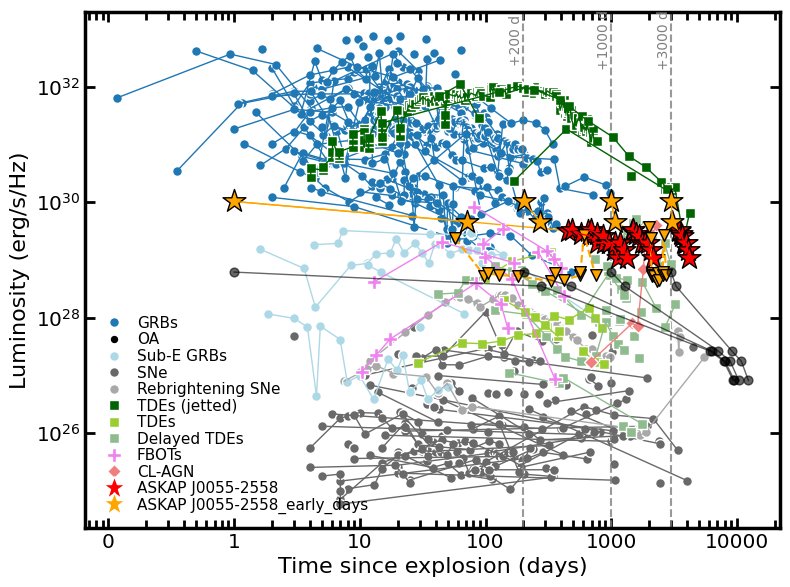

In [20]:
all_data = pd.concat([process_class(path, name) for name, path in class_files.items()], ignore_index=True)

# Drop rows with missing or invalid values in key plotting columns
all_data = all_data.dropna(subset=['t_del(days)', 'Luminosity'])

# Optional: remove masked arrays or string placeholders like '--'
all_data = all_data[~all_data['t_del(days)'].astype(str).str.contains('--')]
all_data = all_data[~all_data['Luminosity'].astype(str).str.contains('--')]

fig=plot_all_classes(all_data)

## Luminosity vs Rest-frame Time plot

In [22]:
import matplotlib.pyplot as plt

def plot_all_classes(all_data):
    
    shifts = [200, 1000, 3000]
    shifted_versions=[]
    shifted_versions_early_days=[]
    shifted_versions_FIRSTOA=[]
    shifted_versions_ASKAP_OA=[]
    
    j0055_df = all_data[all_data['Name'] == "ASKAP J0055-2558"].copy()
    # ASKAP J0055-2558
    for shift in shifts:
        shifted = j0055_df.copy()
        shifted['t_del(days)'] += shift
        shifted['Name'] = f"ASKAP J0055-2558 (+{shift}d)"
        shifted['t_rest(days)'] = shifted['t_del(days)'] / (1 + shifted['Redshift'].astype(float))
        shifted_versions.append(shifted)

    j0055_df_early = all_data[all_data['Name'] == "ASKAP J0055-2558_early_days"].copy()
    # ASKAP J0055-2558_early_days
    for shift in shifts:
        shifted = j0055_df_early.copy()
        shifted['t_del(days)'] += shift
        shifted['Name'] = f"ASKAP J0055-2558_early_days (+{shift}d)"
        shifted['t_rest(days)'] = shifted['t_del(days)'] / (1 + shifted['Redshift'].astype(float))
        shifted_versions_early_days.append(shifted)

    FIRSTOA_df = all_data[all_data['Name'] == "FIRST J141918.9+394036"].copy()
    # FIRST J141918.9+394036
    for shift in shifts:
        shifted = FIRSTOA_df.copy()
        shifted['t_del(days)'] += shift
        shifted['Name'] = f"FIRST J141918.9+394036 (+{shift}d)"
        shifted['t_rest(days)'] = shifted['t_del(days)'] / (1 + shifted['Redshift'].astype(float))
        shifted_versions_FIRSTOA.append(shifted)

    ASKAP_OA_df = all_data[all_data['Name'] == "ASKAP J175036.1-181454"].copy()
    # ASKAP J175036.1-181454
    for shift in shifts:
        shifted = ASKAP_OA_df.copy()
        shifted['t_del(days)'] += shift
        shifted['Name'] = f"ASKAP J175036.1-181454 (+{shift}d)"
        shifted['t_rest(days)'] = shifted['t_del(days)'] / (1 + shifted['Redshift'].astype(float))
        shifted_versions_ASKAP_OA.append(shifted)

    # Combine all into one DataFrame
    all_data = pd.concat([all_data] + shifted_versions + shifted_versions_early_days + shifted_versions_FIRSTOA +shifted_versions_ASKAP_OA, ignore_index=True)
    
    # print(all_data[all_data['Name'].str.contains("ASKAP J0055")][['Name', 't_del(days)', 'Luminosity']])

    
    fig=plt.figure(figsize=(8, 6))

    # Define unique colors
    class_names = all_data['Class'].unique()

    # Define unique markers for broader categories
    plot_style = {
        'GRBs':                     {'marker': 'o', 'alpha': 1, 'size': 50, 'zorder': 1,'color':"tab:blue"},
        "OA":          {'marker': 'o', 'alpha': 0.6, 'size': 40, 'zorder': 100,'color':"black"},
        'Sub-E GRBs':               {'marker': 'o', 'alpha': 1, 'size': 50, 'zorder': 2,'color':"lightblue"},
        'SNe':                      {'marker': 'o', 'alpha': 1, 'size': 50, 'zorder': 1,'color':"dimgrey"},
        'Rebrightening SNe': {'marker': 'o', 'alpha': 1, 'size': 50, 'zorder': 2,'color':"darkgrey"},
        'TDEs (jetted)':                 {'marker': 's', 'alpha': 1, 'size': 50, 'zorder': 7,'color':"darkgreen"},
        'TDEs':             {'marker': 's', 'alpha': 1, 'size': 50, 'zorder': 7,'color':"yellowgreen"},
        'Delayed TDEs':             {'marker': 's', 'alpha': 1, 'size': 50, 'zorder': 7,'color':"darkseagreen"},
        'FBOTs':                    {'marker': 'P', 'alpha': 1, 'size': 100, 'zorder': 9,'color':"violet"},
        'CL-AGN':                    {'marker': 'D', 'alpha': 1, 'size': 50, 'zorder': 20,'color':"lightcoral"},
        "ASKAP J0055-2558":         {'marker': '*', 'alpha': 1, 'size': 300, 'zorder': 100,'color':"red"},
        "ASKAP J0055-2558_early_days": {'marker': '*', 'alpha': 1, 'size': 300, 'zorder': 100,'color':"orange"},
        "ASKAP J175036.1-181454": {'marker': '*', 'alpha': 1, 'size': 250, 'zorder': 100,'color':"blue"}
        
    }

    

    # Track already-used labels to avoid legend clutter
    used_labels = set()

    for class_name, class_df in all_data.groupby('Class'):
        style = plot_style.get(class_name, {'marker': 'o', 'alpha': 0.5, 'size': 30, 'zorder': 1,'color':'gray'})

        for obj_name, group in class_df.groupby('Name'):
            group = group.sort_values(by='t_del(days)')
            label = class_name if class_name not in used_labels else None
          # Use black edge for shifted classes
            if "FIRST" in obj_name:
                edge_col = "black"
            elif "ASKAP" in obj_name:
                edge_col = "black"
            else:
                edge_col = "white"
            if class_name=="ASKAP J0055-2558_early_days":
                # Separate detections from non-detections
                if 'detection' in group.columns:
                    det = group[group['detection'] == True]
                    nondet = group[group['detection'] == False]
                else:
                    det = group
                    nondet = pd.DataFrame()
                # Plot detections with error bars and connecting line
                if not det.empty:
                    plt.errorbar(
                        det['t_rest(days)'].astype(float),
                        det['Luminosity'],
                        yerr=det.get('Luminosity_err', None),
                        fmt='-',
                        lw=1.0,
                        color=style['color'],
                        alpha=style['alpha'],
                        zorder=style['zorder'],
                        markeredgecolor=edge_col
                    )
                    plt.scatter(
                        det['t_rest(days)'].astype(float),
                        det['Luminosity'],
                        marker=style['marker'],
                        color=style['color'],
                        s=style['size'],
                        alpha=style['alpha'],
                        zorder=style['zorder'],
                        label=label,
                        edgecolor=edge_col
                    )

                # Plot non-detections as downward triangles
                if not nondet.empty:
                    nondet_sorted = nondet.sort_values('t_del(days)').copy()
                    mask_nd = pd.to_numeric(nondet_sorted['t_rest(days)'], errors='coerce').astype(float) > 1
                    if mask_nd.any():
                        plt.plot(
                            nondet_sorted.loc[mask_nd, 't_rest(days)'].astype(float),
                            nondet_sorted.loc[mask_nd, 'Luminosity'],
                            linestyle='--',
                            color=style['color'],
                            alpha=style['alpha'],
                            zorder=style['zorder']
                        )

                    # Plot non-detections as triangles
                    plt.scatter(
                        nondet_sorted['t_rest(days)'],
                        nondet_sorted['Luminosity'],
                        marker='v',
                        color=style['color'],
                        s=70,
                        alpha=style['alpha'],
                        zorder=style['zorder'],
                        edgecolor=edge_col,
                        label=None,
                        )
            else:
                plt.errorbar(
                group['t_rest(days)'].astype(float), group['Luminosity'],
                yerr=group.get('Luminosity_err', None),
                fmt='-',  # Only lines
                lw=1.0,
                color=style['color'],
                alpha=style['alpha'],
                zorder=style['zorder'],
                markeredgecolor=edge_col
            )
                plt.scatter(
                    group['t_rest(days)'].astype(float), group['Luminosity'],
                    marker=style['marker'],
                    color=style['color'],
                    s=style['size'],
                    alpha=style['alpha'],
                    zorder=style['zorder'],
                    label=label,
                    edgecolor=edge_col
                )


        used_labels.add(class_name)
    # Combine detections from both ASKAP J0055-2558 and early_days
    combined_name_set = ["ASKAP J0055-2558", "ASKAP J0055-2558_early_days"]
    combined_df = all_data[
        all_data['Name'].isin(combined_name_set) &
        (all_data.get('detection', True) == True)  # handle if detection doesn't exist
    ].copy()
    
    # Connect ASKAP J0055-2558 + early days for original and all shifted versions
    base_names = [
        ("ASKAP J0055-2558", "ASKAP J0055-2558_early_days"),
        ("ASKAP J0055-2558 (+10d)", "ASKAP J0055-2558_early_days (+10d)"),
        ("ASKAP J0055-2558 (+100d)", "ASKAP J0055-2558_early_days (+100d)"),
        ("ASKAP J0055-2558 (+1000d)", "ASKAP J0055-2558_early_days (+1000d)")
    ]

    for late_name, early_name in base_names:
        combined_df = all_data[
            all_data['Name'].isin([late_name, early_name]) &
            (all_data.get('detection', True) == True)
        ].copy()

        if not combined_df.empty:
            combined_df = combined_df.sort_values('t_rest(days)')
            # Use the color from plot_style if available, default to red
            style = plot_style.get(late_name, plot_style.get(early_name, {'color': 'red'}))
            plt.plot(
                combined_df['t_rest(days)'],
                combined_df['Luminosity'],
                linestyle='-',
                color="orange",
                lw=1,
                alpha=1,
                zorder=1
            )


    
    # Create a custom legend using dummy scatter points
    handles = [
        plt.Line2D([0], [0],
            marker=plot_style[cls]['marker'],
            color='w',
            markerfacecolor=plot_style[cls]["color"],
            markersize=np.sqrt(plot_style[cls]['size']),  # size in scatter is area
            label=cls,
            linestyle='None'
        )
        for cls in class_names
    ]

    for shift in shifts:
        plt.axvline(x=shift, color='grey', linestyle='--', linewidth=1.5, alpha=0.8)
        plt.text(shift, plt.ylim()[1]*0.8, f'+{shift} d', rotation=90, color='grey',
                 ha='right', va='center', fontsize=10)

    plt.legend(handles=handles,loc="lower left",handletextpad=0.5,labelspacing=0.1,fontsize =11,frameon=False)

    plt.yscale('log')
    plt.xscale('log')
    plt.tick_params(axis='both', colors='black', direction='in', length=7, width=2,labelsize="x-large")
    plt.tick_params(axis='both',which="minor" ,colors='black', direction='in', length=6, width=2,labelsize="x-large")
    plt.tick_params(which="both",bottom=True, top=True, left=True, right=True)

    plt.gca().spines['top'].set_linewidth(2.5)
    plt.gca().spines['right'].set_linewidth(2.5)
    plt.gca().spines['bottom'].set_linewidth(2.5)
    plt.gca().spines['left'].set_linewidth(2.5)
    plt.gca().xaxis.set_major_formatter(plt.FormatStrFormatter('%0.0f'))
    # plt.gca().xaxis.set_minor_formatter(plt.FormatStrFormatter('%0.0f'))

    plt.xlabel('Rest Frame Time since explosion (days)',fontsize=16)
    plt.ylabel(r'Luminosity (erg s$^{-1}$ Hz$^{-1}$)',fontsize=16)
    
    # plt.title('Radio Luminosity vs Time for All Classes')
    # plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    return fig,all_data

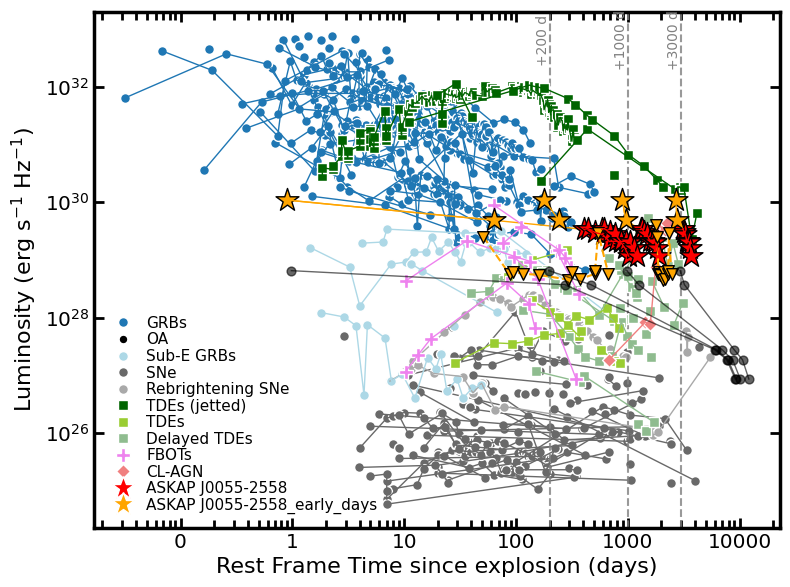

In [23]:
all_data = pd.concat([process_class(path, name) for name, path in class_files.items()], ignore_index=True)

# Drop rows with missing or invalid values in key plotting columns
all_data = all_data.dropna(subset=['t_del(days)', 'Luminosity'])

# Optional: remove masked arrays or string placeholders like '--'
all_data = all_data[~all_data['t_del(days)'].astype(str).str.contains('--')]
all_data = all_data[~all_data['Luminosity'].astype(str).str.contains('--')]

fig,full_dataset=plot_all_classes(all_data)